In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
sys.path.insert(0,'../rl_network/'); import ac
sys.path.insert(0,'../memory/'); import episodic as ec
sys.path.insert(0,'../environments/'); import gw; import gridworld_plotting as gp

In [2]:
import experiment as expt
import torch
import uuid
import csv
import pickle 

def log_experiments(save_id, experiment_type, env, agent, mem = None, **kwargs):
    load = kwargs.get('load', ' ')
    arch_type = kwargs.get('arch', 'B')
    save_flag = kwargs.get('save_flag', False)
    if experiment_type == 0 or save_flag:
        save = f'../data/outputs/gridworld/weights/{save_id}.pt'
        ac.torch.save(agent,save)
    else:
        save = kwargs.get('save', ' ')
    
    pvals = kwargs.get('pvals', False)
    
    
    expt_log = [save_id, experiment_type, load, save]
    # add environment parameters
    if env.maze_type == None:
        maze_type = 'Openfield'
    else:
        maze_type = env.maze_type
    expt_log.append(maze_type)
    expt_log.append(env.shape)
    expt_log.append(len(env.action_list))
    if env.rwd_action == None:
        rwd_action = 'None'
    else:
        rwd_action = env.rwd_action
    expt_log.append(rwd_action)
    expt_log.append(env.rewards)
    expt_log.append(env.step_penalization)
    expt_log.append(env.rho)
    
    # add agent parameters
    expt_log.append(arch_type)
    
    if mem is not None: 
        expt_log.append(mem.mem_temp)
        expt_log.append(pvals)
        expt_log.append(mem.memory_envelope)
        pickle.dump(mem.cache_list, open(f'../data/outputs/gridworld/episodic_cache/{save_id}_EC.p', 'wb'))
    else:
        expt_log.append(-1) # mem_temp = EC_entropy
        expt_log.append(pvals)
        expt_log.append(-1) # Mem_decay
    
    
    
    with open('../data/outputs/gridworld/experiments.csv', 'a+', newline='') as file:
        writer = csv.writer(file)
        if experiment_type is not None:
            writer.writerow(expt_log)
            experiment_type = None
        else:
            raise Exception('enter experiment type ')
    pickle.dump(data, open(f'../data/outputs/gridworld/results/{save_id}_data.p', 'wb'))

In [9]:
reload(expt)
reload(gw)
reload(ac)
rows, columns = 20,20
env_type = 'room'
penalty = -0.01 

NUM_TRIALS = 5000
NUM_EVENTS = 250


reward_location = (15,15)
env = gw.GW_4state(rows=rows,cols=columns,env_type=env_type,
                       rewards = {reward_location:1},
                       step_penalization=penalty,
                       rho=0.0,
                       rewarded_action=None, barheight=10)
    
#fig = gw.plotWorld(env, scale=0.3)
print(env.shape)

(20, 20)


In [10]:
agent_params = {
    'load_model':  False,
    'load_dir':    f'../data/outputs/gridworld/weights/e5857eba-668a-430e-81d7-3d2683f3cea2.pt',
    'freeze_w':    False,

    'input_dims':  env.observation.shape,
    'action_dims': len(env.action_list),
    'hidden_types':['conv','pool','conv', 'pool', 'linear','linear'],
    'hidden_dims': [None, None, None, None, 100, 200],
    'use_SR':      True,

    'rfsize':      5,

    'gamma':       0.98,
    'eta':         5e-4,

    'use_EC':      False,
    'EC':          {},
    'cachelim':    300
    }

In [11]:
print(agent.use_SR)

True


In [ ]:
new = True
for j in range(1):
    if new:
        agent = ac.make_agent(agent_params)
        data = {'total_reward': [],
                'loss': [[],[],[]],
                'trial_length': [],
                'trials_run_to_date':0,
                'pol_tracking':[],
                'val_tracking':[],
                'ec_tracking': [],
                't': [],
                'mfcs':[]
               }
        print(agent)
    mem_temp = 0.1 
    ex = expt.test_expt(agent, env, use_mem=agent_params['use_EC'], mem_temp=0.05)
    save_id = uuid.uuid4()
    
    if not agent_params['load_model']:
        experiment_type = 0
    else:
        if agent_params['freeze_w']:
            if not agent_params['use_EC']:
                experiment_type = 1
            else:
                experiment_type = 2
        else: # weights updating
            if not agent_params['use_EC']:
                experiment_type = 4
            else:
                experiment_type = 5
    #experiment_type = 3 
    print(experiment_type)
    ex.run(NUM_TRIALS, NUM_EVENTS, data)
    if agent_params['use_EC']:
        mem = ex.episodic
    else:
        mem = None
    if agent.use_SR:
        arch = 'B'
    else: 
        arch = 'A'
    log_experiments(save_id, experiment_type, env, agent, mem, save_flag = True, load=agent_params['load_dir'], arch = arch)
    

ActorCritic(
  (hidden): ModuleList(
    (0): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=5, stride=1, padding=1, dilation=1, ceil_mode=False)
    (2): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=5, stride=1, padding=1, dilation=1, ceil_mode=False)
    (4): Linear(in_features=432, out_features=100, bias=True)
    (5): Linear(in_features=100, out_features=200, bias=True)
  )
  (output): ModuleList(
    (0): Linear(in_features=200, out_features=4, bias=True)
    (1): Linear(in_features=200, out_features=1, bias=True)
  )
  (SR): Linear(in_features=200, out_features=200, bias=True)
)
0
0: 0.2999999999999996 (0.13403725624084473s)
500: -2.4999999999999907 (198.5781102180481s)
1000: -2.4999999999999907 (194.49993181228638s)
1500: -2.4999999999999907 (191.1312174797058s)


In [21]:
print(save_id)

f66ce308-b0cf-4b09-8f6b-4e09529267e8


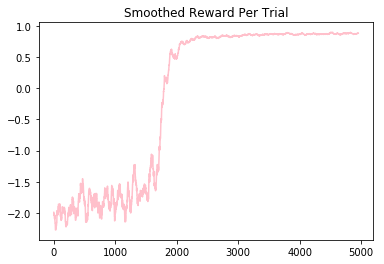

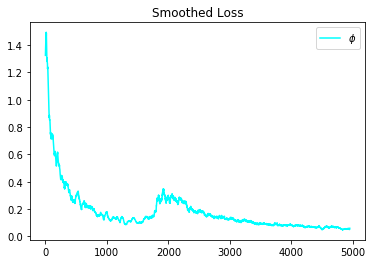

In [22]:
smoothing = 50
plt.figure()
plt.plot(gp.running_mean(data['total_reward'],smoothing),'pink')
plt.title('Smoothed Reward Per Trial')
plt.show()
plt.close()

plt.figure()
#plt.plot(gp.running_mean(data['loss'][0],smoothing), 'darkgreen', label='$\pi$')
#plt.plot(gp.running_mean(data['loss'][1],smoothing), 'lightgreen', label='v')
plt.plot(gp.running_mean(data['loss'][2],smoothing), 'cyan', label='$\phi$')
plt.legend(loc=0)
plt.title('Smoothed Loss')
plt.show()
plt.close()

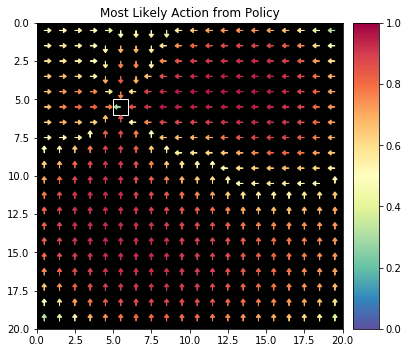

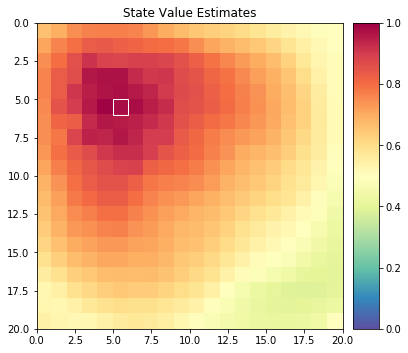

In [23]:
reload(expt)

sample_observations = env.get_sample_obs()
pol_grid, val_grid = expt.get_snapshot(sample_observations, env,agent)
gp.plot_polmap(env, pol_grid, threshold = 0.22)
gp.plot_valmap(env, val_grid, v_range = [0,1])

In [ ]:
print(data['trials_run_to_date'])

In [30]:
save = f'../data/outputs/gridworld/weights/{save_id}.pt'
ac.torch.save(agent,save)

PicklingError: Can't pickle <class 'ac.ActorCritic'>: it's not the same object as ac.ActorCritic

In [67]:
reload(gp)
def ec_policies(maze, EC, trial_timestamp,**kwargs):
    envelope = kwargs.get('decay', 50)
    mem_temp = kwargs.get('mem_temp', 1)
    mpol_array = np.zeros(maze.grid.shape, dtype=[(x, 'f8') for x in maze.action_list])
    
    # cycle through readable states
    for key in EC.cache_list.keys():
        row, col = EC.cache_list[key][2]
        pol = EC.recall_mem(key, timestep = trial_timestamp, mem_temp = mem_temp, print_t=False)
        mpol_array[row,col] = tuple(pol)
        
    return mpol_array
        

abcd = ec_policies(env,ex.episodic, trial_timestamp = 0, mem_temp = 0.5)


0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0


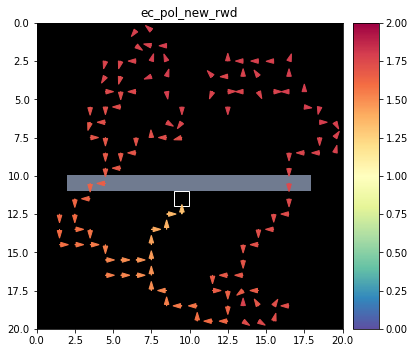

In [68]:
reload(gp)
gp.plot_pref_pol(env, abcd, threshold = 0.1, title='ec_pol_new_rwd',upperbound=2)

In [69]:
state = (4,3)
env.set_state(env.twoD2oneD(state))
observation = torch.Tensor(np.expand_dims(env.get_observation(), axis=0))
policy_, value_, phi_, psi_ = agent(observation)

lin_act = tuple(np.round(phi_.data[0].numpy(),4))
key, sim = ex.episodic.cosine_sim(lin_act)

mem_state = ex.episodic.cache_list[key]

In [ ]:
print(mem_state)
print(ex.episodic.recall_mem(lin_act, timestep=0))
#print(abcd[state])
plt.bar(np.arange(4),ex.episodic.recall_mem(lin_act, timestep=0))
#MF_alone = data

In [ ]:
ex.mem_temp